##### Copyright 2019 The TF-Agents Authors.

### Get Started
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/10_checkpointer_policysaver_tutorial.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/agents/blob/master/docs/tutorials/10_checkpointer_policysaver_tutorial.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

### Imports

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import io
import matplotlib
import matplotlib.pyplot as plt
import os
import shutil
import tempfile
import tensorflow as tf
import zipfile
import IPython

"""
try:
  from google.colab import files
except ImportError:
  files = None
"""

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import policy_saver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()

# tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())

In [2]:
#@test {"skip": true}
# Set up a virtual display for rendering OpenAI gym environments.
# import xvfbwrapper
# xvfbwrapper.Xvfb(1400, 900, 24).start()

### Introduction

`tf_agents.utils.common.Checkpointer` is a utility to save/load the training state, policy state, and reply_buffer state to/from a local storage.

`tf_agents.policies.policy_saver.PolicySaver` is a tool to save/load only the policy, and is lighter than `Checkpointer`. You can use `PolicySaver` to deploy the model as well without any knowledge of the code that created the policy.

In this tutorial, we will use DQN to train a model, then use `Checkpointer` and `PolicySaver` to show how we can store and load the states and model in an interactive way. Note that we will use TF2.0's new saved_model tooling and format for `PolicySaver`.


### Setting up DQN agent
We are going to set up DQN agent, just like in the previous colab. The details are hidden by default as they are not core part of this colab, but you can click on 'SHOW CODE' to see the details.

#### Hyperparameters

In [3]:
env_name = "CartPole-v1"

collect_steps_per_iteration = 100
replay_buffer_capacity = 100000

fc_layer_params = (100,)

batch_size = 64
learning_rate = 1e-3
log_interval = 5

num_eval_episodes = 10
eval_interval = 1000

#### Environment

In [4]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

#### Agent

In [5]:
#@title
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

global_step = tf.compat.v1.train.get_or_create_global_step()

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=global_step)
agent.initialize()

#### Data Collection

In [6]:
#@title
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=collect_steps_per_iteration)

# Initial data collection
collect_driver.run()

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

#### Train the agent

In [7]:
#@title
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

def train_one_iteration():

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_driver.run()

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience)

  iteration = agent.train_step_counter.numpy()
  print ('iteration: {0} loss: {1}'.format(iteration, train_loss.loss))

#### Video Generation

In [8]:
#@title
def embed_gif(gif_buffer):
  """Embeds a gif file in the notebook."""
  tag = '<img src="data:image/gif;base64,{0}"/>'.format(base64.b64encode(gif_buffer).decode())
  return IPython.display.HTML(tag)

def run_episodes_and_create_video(policy, eval_tf_env, eval_py_env):
  num_episodes = 3
  frames = []
  for _ in range(num_episodes):
    time_step = eval_tf_env.reset()
    frames.append(eval_py_env.render())
    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = eval_tf_env.step(action_step.action)
      frames.append(eval_py_env.render())
  gif_file = io.BytesIO()
  imageio.mimsave(gif_file, frames, format='gif', fps=60)
  IPython.display.display(embed_gif(gif_file.getvalue()))

#### Generate a video
Check the performance of the policy by generating a video.

global_step:
<tf.Variable 'global_step:0' shape=() dtype=int64, numpy=0>



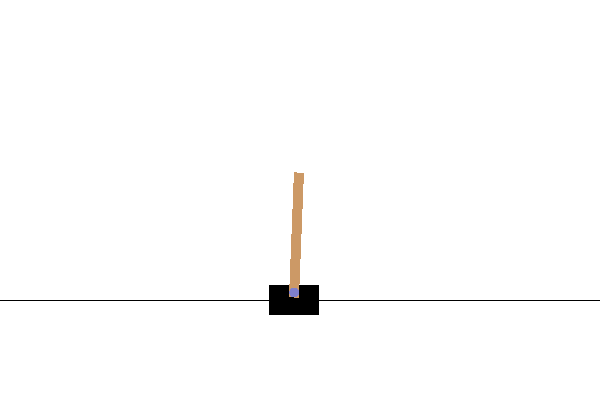

In [9]:
print ('global_step:')
print (global_step)
run_episodes_and_create_video(agent.policy, eval_env, eval_py_env)

### Introducing Checkpointer and PolicySaver

Now we are ready to use Checkpointer and PolicySaver.

#### Checkpointer


In [10]:
checkpoint_dir = os.path.join(os.getcwd(), 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=global_step
)

####Policy Saver

In [11]:
policy_dir = os.path.join(os.getcwd(), 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

#### Train one iteration

In [12]:
#@test {"skip": true}
print('Training one iteration....')
train_one_iteration()

Training one iteration....
iteration: 1 loss: 0.960686206817627


#### Save to checkpoint

In [13]:
train_checkpointer.save(global_step)

#### Restore checkpoint
For this to work, the whole set of objects should be recreated the same way as when the checkpoint was created.

In [14]:
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

#### Also save policy and export to a location

In [15]:
tf_policy_saver.save(policy_dir)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: C:\Users\Mark\Documents\programming_projects\southampton_uni\Online-Flexible-Resource-Allocation\tutorials\policy\assets


INFO:tensorflow:Assets written to: C:\Users\Mark\Documents\programming_projects\southampton_uni\Online-Flexible-Resource-Allocation\tutorials\policy\assets


#### Load the saved policy and check how it performs
The policy can be loaded without having any knowledge of what agent or network was used to create it. This makes deployment of the policy much easier.


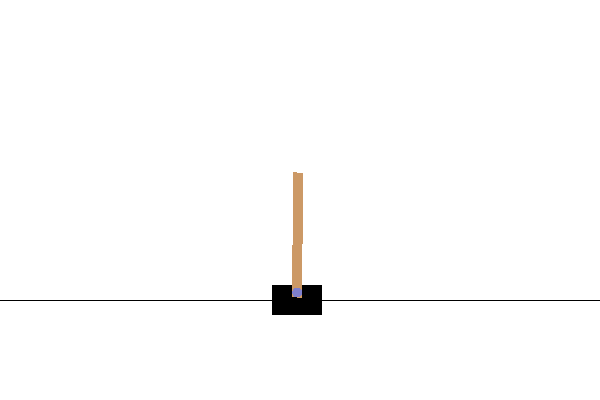

In [16]:
saved_policy = tf.compat.v2.saved_model.load(policy_dir)
run_episodes_and_create_video(saved_policy, eval_env, eval_py_env)

### Export and import
The rest of the colab will help you export / import checkpointer and policy directories such that you can continue training at a later point and deploy the model without having to train again.

Now you can go back to 'Train one iteration' and train a few more times such that you can understand the difference later on. Once you start to see slightly better results, continue below.

In [17]:
#@title Create zip file and upload zip file (double-click to see the code)
def create_zip_file(dirname, base_filename):
  return shutil.make_archive(base_filename, 'zip', dirname)

def upload_and_unzip_file_to(dirname):
  if files is None:
    return
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    shutil.rmtree(dirname)
    zip_files = zipfile.ZipFile(io.BytesIO(uploaded[fn]), 'r')
    zip_files.extractall(dirname)
    zip_files.close()

Create a zipped file from the checkpoint directory.

In [18]:
train_checkpointer.save(global_step)
checkpoint_zip_filename = create_zip_file(checkpoint_dir, os.path.join(tempdir, 'exported_cp'))

NameError: name 'tempdir' is not defined

Download the zip file.

In [ ]:
#@test {"skip": true}
if files is not None:
  files.download(checkpoint_zip_filename) # try again if this fails: https://github.com/googlecolab/colabtools/issues/469

After training for some time (10-15 times), download the checkpoint zip file,
and go to "Runtime > Restart and run all" to reset the training,
and come back to this cell. Now you can upload the downloaded zip file,
and continue the training.

In [ ]:
#@test {"skip": true}
upload_and_unzip_file_to(checkpoint_dir)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

Once you have uploaded checkpoint directory, go back to 'Train one iteration' to continue training or go back to 'Generate a video' to check the performance of the loaded poliicy.

Alternatively, you can save the policy (model) and restore it.
Unlike checkpointer, you cannot continue with the training, but you can still deploy the model. Note that the downloaded file is much smaller than that of the checkpointer.

In [ ]:
tf_policy_saver.save(policy_dir)
policy_zip_filename = create_zip_file(policy_dir, os.path.join(tempdir, 'exported_policy'))

In [ ]:
#@test {"skip": true}
if files is not None:
  files.download(policy_zip_filename) # try again if this fails: https://github.com/googlecolab/colabtools/issues/469

Upload the downloaded policy directory (exported_policy.zip) and check how the saved policy performs.

In [ ]:
#@test {"skip": true}
upload_and_unzip_file_to(policy_dir)
saved_policy = tf.compat.v2.saved_model.load(policy_dir)
run_episodes_and_create_video(saved_policy, eval_env, eval_py_env)


###SavedModelPyTFEagerPolicy

If you don't want to use TF policy, then you can also use the saved_model directly with the Python env through the use of `py_tf_eager_policy.SavedModelPyTFEagerPolicy`.

Note that this only works when eager mode is enabled.

In [ ]:
eager_py_policy = py_tf_eager_policy.SavedModelPyTFEagerPolicy(
    policy_dir, eval_py_env.time_step_spec(), eval_py_env.action_spec())

# Note that we're passing eval_py_env not eval_env.
run_episodes_and_create_video(eager_py_policy, eval_py_env, eval_py_env)